In [1]:
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd
import folium, h3, json
from shapely.geometry import Polygon, Point
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import seaborn as sns

In [49]:
# Import the dataset
df = pd.read_csv('clean_taxi_data.csv')

# load the census tract areas as a geodataframe
census_gdf = gpd.read_file('Boundaries.geojson', crs='epsg:4326')

# load the spatial feature map as a geodataframe
spatial_features = gpd.read_file('spatial_features_hex7.geojson', crs='epsg:4326')

# Load the weather dataset
weather = pd.read_csv('weather_chic.csv')

In [50]:
# Drop unnecessary columns from both DataFrames
df.drop(['Unnamed: 0','taxi_id','dropoff_location','dropoff_census'],axis=1,inplace=True)
weather.drop(['name','dew','humidity','windgust','winddir','sealevelpressure','cloudcover',
         'visibility','solarradiation','solarenergy','uvindex','conditions','icon','stations','Unnamed: 0'],axis=1,inplace=True)

<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        Define important functions
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [4]:
def perform_svr_grid_search(X_train: pd.DataFrame, y_train: pd.Series, use_rbf_kernel: bool = False) -> GridSearchCV:
    """
    Perform grid search to tune the hyperparameters of an SVR model using cross-validation.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target values.
    - use_rbf_kernel (bool): If True, include gamma in the parameter grid for RBF kernel.

    Returns:
    - GridSearchCV: The fitted GridSearchCV object with the best parameters.
    """
    
    # Define the base parameter grid for SVR hyperparameters
    param_grid = {
        'svr__C': [0.1, 1, 10, 100],
        'svr__epsilon': [0.1, 0.5, 1, 5],
        'svr__kernel': ['linear', 'rbf', 'poly']
    }
    
    # Add gamma to the parameter grid if RBF kernel is specified
    if use_rbf_kernel:
        param_grid['svr__gamma'] = [0.0001, 0.001, 0.005]

    # Create a pipeline that first scales the data then applies SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Data scaling step
        ('svr', SVR())                 # SVR model step
    ])

    # Set up GridSearchCV with cross-validation and parallel processing
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        refit=True,     # Refit the model with the best parameters
        verbose=1,      # Print detailed progress
        n_jobs=-1,      # Use all available processors
        cv=3            # Number of cross-validation folds
    )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters found
    print(f"Optimal Parameters: {grid_search.best_params_}")
    
    return grid_search


In [5]:
def convert_point_to_hexagon(point_wkt: str, hex_resolution: int) -> str:
    """
    Convert a Well-Known Text (WKT) point string to an H3 hexagon ID.

    Parameters:
    - point_wkt (str): The Well-Known Text (WKT) representation of a point.
    - hex_resolution (int): The resolution of the H3 hexagon (0-15).

    Returns:
    - hex_id (str): The H3 hexagon ID corresponding to the point.
    """
    
    # Convert the WKT point string to a Point object
    point_obj = wkt.loads(point_wkt)
    
    # Convert the latitude and longitude of the Point object to an H3 hexagon ID
    hex_id = h3.geo_to_h3(point_obj.y, point_obj.x, hex_resolution)
    
    return hex_id


In [6]:
def train_svm_kernel(X_train, y_train, X_test, kernel_type: str, C=1, epsilon=0.1, degree=3, gamma='scale'):
    """
    Train an SVM model with a specified kernel and evaluate its performance.

    Parameters:
    - X_train: Training feature data.
    - y_train: Training target data.
    - X_test: Testing feature data.
    - kernel_type (str): The type of kernel to use ('poly', 'linear', 'rbf', 'sigmoid').
    - C (float): Regularization parameter. Default is 1.
    - epsilon (float): Epsilon in the epsilon-SVR model. Default is 0.1.
    - degree (int): Degree of the polynomial kernel function ('poly'). Ignored by other kernels. Default is 3.
    - gamma (str): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Default is 'scale'.

    Returns:
    - svr_model: The trained SVM model.
    - scaler: The scaler used to standardize the training and testing data.
    """
    
    # Validate the kernel type
    if kernel_type not in ['poly', 'linear', 'rbf', 'sigmoid']:
        raise ValueError("kernel_type must be one of 'poly', 'linear', 'rbf', or 'sigmoid'")
    
    # Standardize the training and testing data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize the SVR model based on the kernel type
    if kernel_type in ['linear', 'sigmoid']:
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon)
    elif kernel_type == 'poly':
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon, degree=degree)
    elif kernel_type == 'rbf':
        svr_model = SVR(kernel=kernel_type, C=C, epsilon=epsilon, gamma=gamma)

    # Train the SVM model
    svr_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_pred = svr_model.predict(X_test_scaled)

    # Evaluate the model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation results
    print(f'RESULTS of {kernel_type}-kernel:\n-----------------------------------------')
    print("Mean Absolute Error (MAE):       ", round(mae, 2))
    print("Mean Squared Error (MSE):        ", round(mse, 2))
    print("Root Mean Squared Error (RMSE):  ", round(rmse, 2))
    print("R-squared (R²):                  ", round(r2, 4))
    print('-----------------------------------------')

    # Return the trained model and the scaler
    return svr_model, scaler

In [7]:
def stacked_svm_predict(X_test, meta_model, *kernel_models):
    """
    Make predictions using pre-trained SVM kernels and a pre-trained meta-model.

    Parameters:
    - X_test: Test features for which predictions are required.
    - meta_model: The pre-trained meta-model that will combine the kernel predictions.
    - kernel_models: A variable number of tuples where each tuple contains:
        - A list of feature names corresponding to the kernel.
        - The pre-fitted scaler for those features.
        - The pre-trained SVM model.

    Returns:
    - predictions_df: A DataFrame containing predictions from each kernel and the final stacked model.
    """

    # List to hold predictions from each kernel for the testing data
    test_predictions = []

    # Iterate over each provided SVM kernel, its corresponding features, and scaler
    for features, scaler, svm_model in kernel_models:
        # Scale the relevant features for the current kernel using the provided scaler
        X_test_scaled = scaler.transform(X_test[features])

        # Predict using the trained kernel on the scaled testing data
        test_pred = svm_model.predict(X_test_scaled)

        # Store the predictions
        test_predictions.append(test_pred)

    # Stack the predictions from all kernels as input to the meta-model
    X_meta_test = np.column_stack(test_predictions)

    # Make final predictions using the meta-model on the test data
    y_final_pred = meta_model.predict(X_meta_test)

    # Create a DataFrame to store all predictions
    predictions_df = pd.DataFrame({
        'Meta_Prediction': y_final_pred
    })

    # Add each kernel's prediction to the DataFrame
    for i, (features, scaler, svm_model) in enumerate(kernel_models):
        predictions_df[f'Kernel_{i+1}_Prediction'] = test_predictions[i]

    return predictions_df

In [8]:
def create_prediction_map(selected_hour: int, prediction_data: pd.DataFrame):
    """
    Create a folium map that visualizes predictions for a specific hour.

    Parameters:
    - selected_hour (int): The hour of the day for which predictions should be displayed (0-23).
    - prediction_data (pd.DataFrame): The DataFrame containing prediction data, geometry, and other relevant features.

    Returns:
    - folium.Map: A Folium map object with predictions visualized for the selected hour.
    """
    
    # Validate the hour input to ensure it is between 0 and 23
    if selected_hour not in range(24):
        raise ValueError('selected_hour must be between 0 and 23')
        
    # Filter the prediction data for the specified hour
    hourly_data = prediction_data[prediction_data['hour'] == selected_hour].copy()
    
    # Create a log column for the colormap
    shift = abs(hourly_data['Meta_Prediction'].min()) + 1
    hourly_data['Meta_Prediction_Log'] = np.log1p(hourly_data['Meta_Prediction'] + shift)

    # Create a Folium map to explore predictions for the selected hour
    map_object = hourly_data.explore(
        column='Meta_Prediction_Log',  # Column to base the color on
        cmap='Reds',               # Color map for predictions
        legend=True,               # Display a legend on the map
        style_kwds=dict(color="black", weight=1, opacity=0.4, fillOpacity=.9),
        tooltip=['h3_hex_id', 'Meta_Prediction', 'num_hotels'],  # Tooltip columns
        popup=True,                # Enable popups with all columns
    )

    # Add text labels on the map for each prediction
    for _, row in hourly_data.iterrows():
        # Calculate the centroid of the geometry to place the label
        centroid = row['geometry'].centroid
    
        # Add a marker with a label showing the rounded prediction value
        folium.Marker(
            location=[centroid.y, centroid.x],
            icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black">{int(round(row['Meta_Prediction'], 0))}</div>""")
        ).add_to(map_object)

    return map_object


<div>
    <span style ="font-size: 30px; font-weight: bold; color: #8EB944">
        TEST
    </span>
    
<hr style="color: #8EB944; height: 3px;background-color: #8EB944;border: none">
</div>

In [51]:
# Replace the values in the preciptpe column with numerical values
weather['snow_binary'] = weather['preciptype'].apply(lambda x: 1 if x == 'snow' or x == 'rain,snow'  else 0)
weather['rain_binary'] = weather['preciptype'].apply(lambda x: 1 if x == 'rain' or x == 'rain,snow' else 0)

In [52]:
# Apply the function to your DataFrame
df['h3_hex_id'] = df.pickup_location.apply(lambda x: convert_point_to_hexagon(x, 7))

# Convert the Times to the datetime format
df['trip_start'] = pd.to_datetime(df.trip_start)
weather['datetime'] = pd.to_datetime(weather.datetime)


# Round the time in the df to the nearest hour
df['rounded_time'] = df['trip_start'].dt.floor('H')

# Merge the dataframes
df = pd.merge(df, weather, left_on='rounded_time', right_on='datetime', how='left')

# Drop the (now) unnecesarry columns
df.drop(['datetime','trip_end','end_day','start_time','end_time','start_day','preciptype'],axis=1,inplace=True)

In [53]:
# Aggregate the dataframe so that it just contains the number of rides for each hexagon and time resolution
df_grouped = df.groupby(['rounded_time', 'h3_hex_id']).agg(
    rides=('h3_hex_id', 'size'),  
    trip_seconds =('trip_seconds', 'mean'),
    trip_miles =('trip_miles', 'mean'), 
    fare=('fare', 'first'), 
    temp=('temp','first'), # All weather values are the same for the hour, so we take the first
    precip =('precip','first'), 
    preciprob=('precipprob','first'),
    snow=('snow','first'),
    snowdepth=('snowdepth','first'),
    windspeed=('windspeed','first'),
    severerisk=('severerisk','first'),
    snow_binary =('snow_binary','first'),
    rain_binary = ('rain_binary','first'),
).reset_index()

In [54]:
# Merge the spatial features with the DataFrame
df_final = pd.merge(df_grouped, spatial_features, on='h3_hex_id', how='left')

In [55]:
df_final['hour'] = df_final['rounded_time'].dt.hour
df_final['day_of_week'] = df_final['rounded_time'].dt.dayofweek  # Monday=0, Sunday=6
df_final['month'] = df_final['rounded_time'].dt.month
df_final['weekend_binary'] = df_final['rounded_time'].dt.dayofweek >= 5 
df_final['bar_hours'] = df_final['hour'].apply(lambda x: 0 if x <= 18 and x >= 4 else 1)
df_final['morning_commuting'] = df_final['hour'].apply(lambda x: 1 if x >= 5 and x<= 10 else 0)
df_final['evening_commuting'] = df_final['hour'].apply(lambda x: 1 if x>= 13 and x<= 18 else 0)
df_final['bar_hours_weekend'] = df_final['bar_hours'] * df_final['weekend_binary']
df_final['morning_commuting_week'] = df_final['morning_commuting'] * (1-df_final['weekend_binary'])
df_final['evening_commuting_week'] = df_final['evening_commuting'] * (1-df_final['weekend_binary'])

Text(0.5, 1.0, 'Correlation Heatmap')

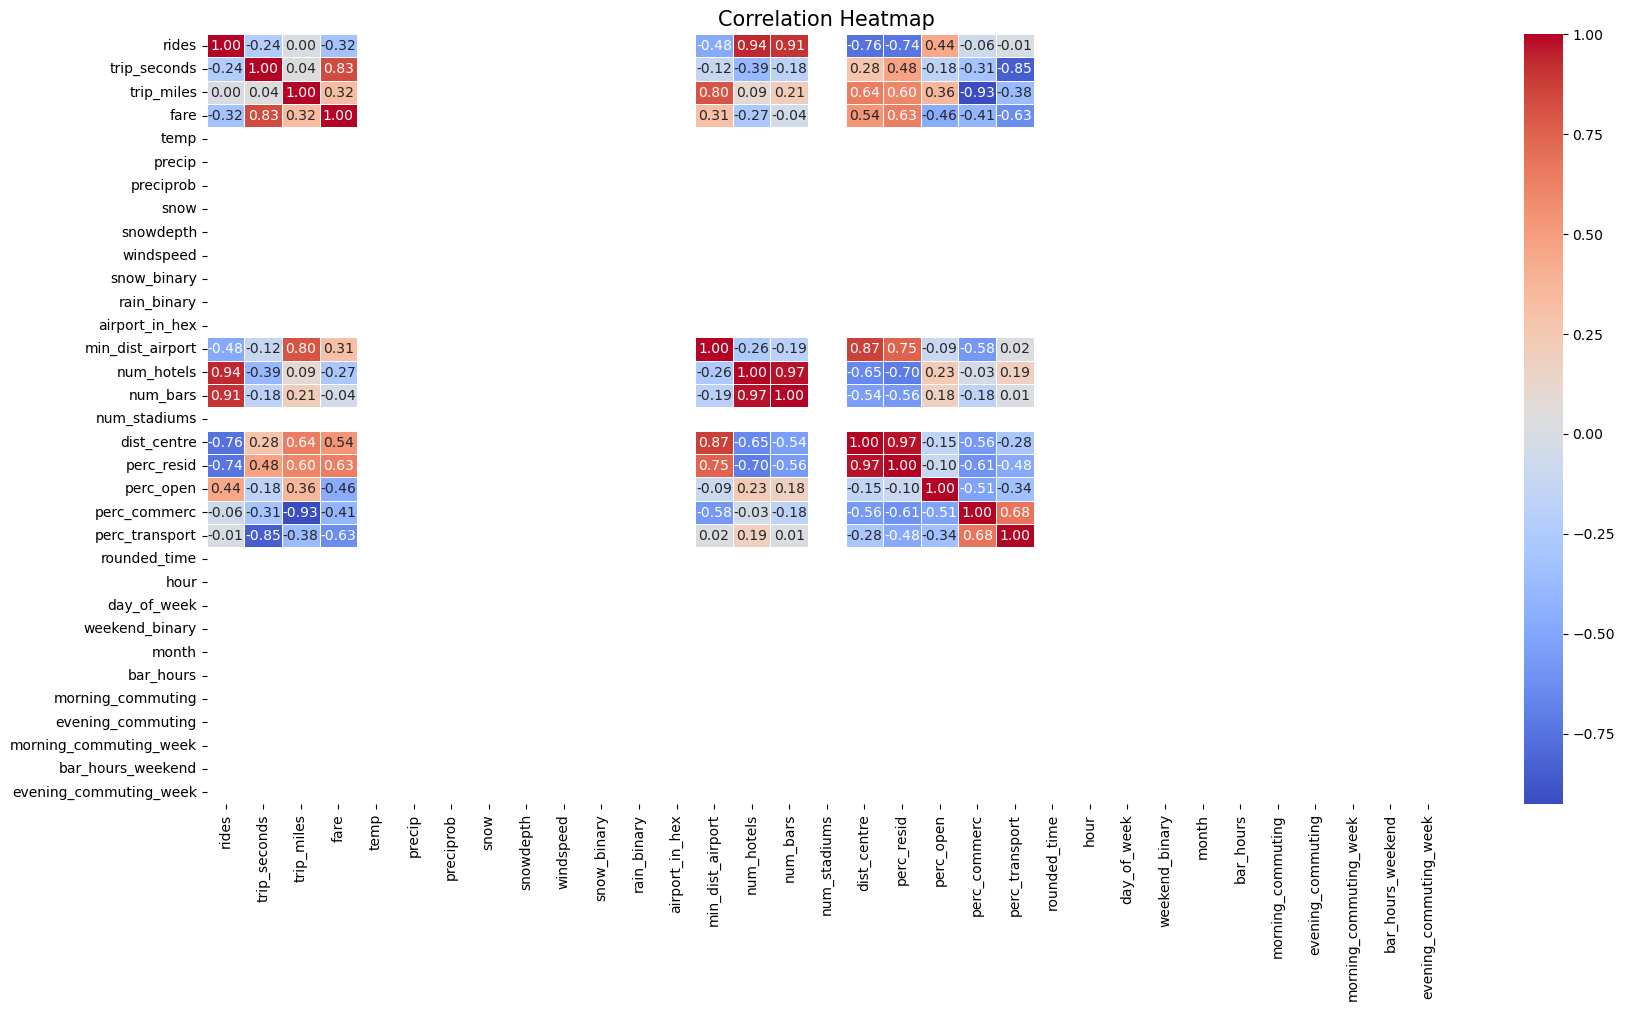

In [56]:
corr_matrix = df_final[['rides','trip_seconds','trip_miles','fare','temp',
                       'precip', 'preciprob', 'snow', 'snowdepth', 'windspeed',
       'snow_binary', 'rain_binary', 'airport_in_hex',
       'min_dist_airport', 'num_hotels', 'num_bars', 'num_stadiums',
       'dist_centre', 'perc_resid', 'perc_open', 'perc_commerc',
       'perc_transport','rounded_time','hour','day_of_week','weekend_binary','month','bar_hours','morning_commuting','evening_commuting'
                       ,'morning_commuting_week','bar_hours_weekend','evening_commuting_week']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Create a heatmap with the correlation matrix, including correlation coefficients
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# Set the title for the heatmap
plt.title('Correlation Heatmap', size=15)

In [15]:
df_test = df_final.sample(n=10000, axis=0,random_state=42)

In [16]:
# Split the DataSet into features (X) and dependent variable (Y)
independent_variables = ['trip_seconds', 'trip_miles',
       'fare', 'temp', 'precip', 'preciprob', 'snow', 'snowdepth', 'windspeed',
        'snow_binary', 'rain_binary', 
       'min_dist_airport', 'dist_centre', 'num_stadiums', 'num_hotels',
       'num_bars', 'airport_in_hex', 'perc_transport', 'perc_resid',
       'perc_commerc', 'perc_open', 'hour', 'day_of_week', 'month',
       'weekend_binary', 'bar_hours', 'morning_commuting', 'evening_commuting',
       'bar_hours_weekend', 'morning_commuting_week',
       'evening_commuting_week']

# Define the X and Y Variables
X = df_test[independent_variables]
y = df_test['rides']

# First split: train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Second split: train and validation from the train+val set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=12)

In [17]:
# Define the features for poly kernel
features_poly = ['num_hotels', 'num_bars', 'dist_centre', 'perc_transport',
       'evening_commuting_week', 'bar_hours','hour']

# Define the test and train features
X_train_poly = X_train[features_poly]
X_test_poly = X_test[features_poly]

# Fit the model
poly_model,scaler_poly = train_svm_kernel(X_train_poly, y_train,X_test_poly,'poly',C=10,epsilon=5,degree=4)

RESULTS of poly-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        13.55
Mean Squared Error (MSE):         3283.42
Root Mean Squared Error (RMSE):   57.3
R-squared (R²):                   0.7866
-----------------------------------------


In [18]:
perform_svr_grid_search(X_val[features_poly],y_val,use_rbf_kernel=False)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Optimal Parameters: {'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel': 'poly'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [34]:
# Define the features for poly kernel
features_rbf = ['perc_transport','perc_commerc','perc_resid','perc_open','temp']

# Define the test and train features
X_train_rbf = X_train[features_rbf]
X_test_rbf = X_test[features_rbf]

# Fit the model
rbf_model,scaler_rbf = train_svm_kernel(X_train_rbf, y_train,X_test_rbf,'rbf',C=100,epsilon=5, gamma=2)

RESULTS of rbf-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        18.59
Mean Squared Error (MSE):         6730.88
Root Mean Squared Error (RMSE):   82.04
R-squared (R²):                   0.5624
-----------------------------------------


In [20]:
perform_svr_grid_search(X_val[features_rbf],y_val,use_rbf_kernel=True)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Optimal Parameters: {'svr__C': 100, 'svr__epsilon': 5, 'svr__gamma': 0.005, 'svr__kernel': 'rbf'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__gamma': [0.0001, 0.001, 0.005],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [44]:
# Define the features for poly kernel
features_linear = ['weekend_binary','airport_in_hex','windspeed','snow_binary','min_dist_airport','num_hotels','num_bars','evening_commuting_week',
                  'morning_commuting_week']

# Define the test and train features
X_train_linear = X_train[features_linear]
X_test_linear = X_test[features_linear]

# Fit the model
linear_model,scaler_linear = train_svm_kernel(X_train_linear, y_train,X_test_linear,'linear',C=10,epsilon=5)

RESULTS of linear-kernel:
-----------------------------------------
Mean Absolute Error (MAE):        19.79
Mean Squared Error (MSE):         6777.79
Root Mean Squared Error (RMSE):   82.33
R-squared (R²):                   0.5594
-----------------------------------------


In [36]:
perform_svr_grid_search(X_val[features_linear],y_val,use_rbf_kernel=False)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Optimal Parameters: {'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel': 'linear'}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.5, 1, 5],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [45]:
# Generate predictions for the training data using the fitted scalers
poly_prediction = poly_model.predict(scaler_poly.transform(X_train[features_poly]))
rbf_prediction = rbf_model.predict(scaler_rbf.transform(X_train[features_rbf]))

# Generate predictions for the test data using the same scalers
poly_prediction_test = poly_model.predict(scaler_poly.transform(X_test[features_poly]))
rbf_prediction_test = rbf_model.predict(scaler_rbf.transform(X_test[features_rbf]))

# Combine predictions to create the meta model training data
X_meta_train = np.column_stack((poly_prediction, rbf_prediction))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta_train, y_train)

# Combine predictions for test data to create the meta model test data
X_meta_test = np.column_stack((poly_prediction_test, rbf_prediction_test))

# Predict using the meta-model
y_pred = meta_model.predict(X_meta_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Output results
print(f'RESULTS:\n-----------------------------------------')
print("Mean Absolute Error (MAE):       ", round(mae, 2))
print("Mean Squared Error (MSE):        ", round(mse, 2))
print("Root Mean Squared Error (RMSE):  ", round(rmse, 2))
print("R-squared (R²):                  ", round(r2, 4))
print('-----------------------------------------')     

RESULTS:
-----------------------------------------
Mean Absolute Error (MAE):        13.66
Mean Squared Error (MSE):         2981.5
Root Mean Squared Error (RMSE):   54.6
R-squared (R²):                   0.8062
-----------------------------------------


In [46]:
# Define the hours of the day (0-23)
hours = list(range(24))

# Define the conditions for morning_commuting, bar_hours, and evening_commuting
morning_commuting = [1 if 5 <= hour <= 10 else 0 for hour in hours]
bar_hours = [0 if 5 <= hour <= 19 else 1 for hour in hours]
evening_commuting = [1 if 13 <= hour <= 18 else 0 for hour in hours]

# Create the DataFrame
time_info = pd.DataFrame({
    'hour': hours,
    'morning_commuting': morning_commuting,
    'bar_hours': bar_hours,
    'evening_commuting_week': evening_commuting
})

spatial_features['temp'] = weather['temp'].median()

prediction_map = spatial_features.merge(time_info,how='cross')

data = stacked_svm_predict(
    prediction_map,   # The test features DataFrame
    meta_model,       # The meta-model for stacking
    (features_poly, scaler_poly, poly_model),  # First kernel model
    (features_rbf, scaler_rbf, rbf_model)  # Second kernel model
)

# Concatenate the predictions with the original DataFrame
prediction_map = pd.concat([prediction_map, data], axis=1)

map_chicago = create_prediction_map(8,prediction_map)

map_chicago